# Train CycleGAN Notebook

This notebook realizes a quick training of a CycleGAN (stabilityAI/sd-turbo) using merlin's BosonSampler on day and night car images (small part of dataset BDD-100k). The CycleGAN was pretrained on the whole dataset and the idea was then to add a BosonSampler, before the decoder, and to train only the decoder. This method has shown some results on a challenge organized by BMW and Airbus to turn driving in the day images into driving in the night images. The original architecture was based on this github https://github.com/GaParmar/img2img-turbo. We did a first training without any quantum layers and then a second one, starting from the pretained weights and adding a quantum layer. The notebook here is a small reproduction of the second training, with a dataset of only 200 images. The dataset is not directly in the MerLin repository, however you can specify where to download it with the _args.dataset_folder_ variable. It goes the same for the outputs of the model with the _args.output_dir_ variable. Be careful: it is necessary to have access to a cuda device to run this model

In [1]:
import torch
import gc
import copy
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
import numpy as np
import lpips
from accelerate import Accelerator
from accelerate.ut+ils import set_seed
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, CLIPTextModel
from diffusers.optimization import get_scheduler
from peft.utils import get_peft_model_state_dict
from cleanfid.fid import get_folder_features, build_feature_extractor, frechet_distance
import vision_aided_loss
from model import make_1step_sched
from cyclegan_turbo import CycleGAN_Turbo, VAE_encode, VAE_decode, initialize_unet, initialize_vae
from my_utils.training_utils import UnpairedDataset, build_transform, parse_args_unpaired_training, \
    UnpairedDataset_Quantum, get_next_id, read_from_emb16, image_fail, read_from_emb32, load_small_dataset
from my_utils.dino_struct import DinoStructureLoss
import h5py
import torch.nn.init as init
import pandas as pd
from BosonSampler import BosonSampler
import time
import shutil
import argparse
from types import SimpleNamespace
import os
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

### Adjust key parameters and variables

In [2]:
def parse_args_unpaired_training():
    """
    Parses command-line arguments used for configuring an unpaired session (CycleGAN-Turbo).
    This function sets up an argument parser to handle various training options.

    Returns:
    argparse.Namespace: The parsed command-line arguments.
   """

    
    args = {}
    # fixed random seed
    args["seed"] = 42
 # args for the loss function
    args["gan_disc_type"] = "vagan_clip"
    args["gan_loss_type"] = "multilevel_sigmoid"
    args["lambda_gan"] = 0.5
    args["lambda_idt"] = 1
    args["lambda_cycle"] = 1
    args["lambda_cycle_lpips"] = 10.0
    args["lambda_idt_lpips"] = 1.0

    # args for dataset and dataloader options
    args["dataset_folder"] = '../dataset'                                                      
    args["train_img_prep"] = 'resize_128'                                                                  
    args["val_img_prep"] = 'resize_128'                                                                   
    args["dataloader_num_workers"] = 0                                                    
    args["train_batch_size"] = 2                                                                                                                    
    args["max_train_epochs"] = 20                                                       
    args["max_train_steps"] = 20                                                                                                                                                                                           
                          
    args["revision"] = None                                                               
    args["variant"] = None                                                              
    args["lora_rank_unet"] = 128                                                        
    args["lora_rank_vae"] = 4                                                                                                                                                                                  
    # args for validation and logging                                                                                       
    args["viz_freq"] = 20 
    args["output_dir"] = '../outputs'                                     
    args["validation_steps"] = 50              
    args["validation_num_images"] = -1
    args["checkpointing_steps"] = 1000

    # args for the optimization options
    args["learning_rate"] = 1e-5
    args["adam_beta1"] = 0.9
    args["adam_beta2"] = 0.999
    args["adam_weight_decay"] = 1e-2
    args["adam_epsilon"] = 1e-08        
    args["max_grad_norm"] = 10.0
    args["lr_scheduler"] = "constant"                                                                                                                     
    args["lr_warmup_steps"] = 500
    args["lr_num_cycles"] = 1                                                                                                        
    args["lr_power"] = 1.0       
    args["gradient_accumulation_steps"] = 1                                                                                                                                                                    # memory saving options
    args["allow_tf32"] = False
    args["gradient_checkpointing"] = False
    args["enable_xformers_memory_efficient_attention"] = True


    # dynamic conditional quantum embeddings with the VAE frozen
    args["quantum_dynamic"] = True
    args["cl_comp"] = False
    args["pretrained_model_path"] = "model_251.pkl"
    args["quantum_dims"] = (4, 16, 16)
    args["quantum_processes"] = 2
    args["training_images"] = 1.
    return SimpleNamespace(**args)

In [3]:
args = parse_args_unpaired_training()


### Loading Boson Sampler

In [4]:
if args.quantum_dynamic:                                                                                                    
    # Set the random seeds
    torch.manual_seed(args.seed)
    print("boson sampler dims", (args.quantum_processes, ) + args.quantum_dims)
    boson_sampler = BosonSampler((args.quantum_processes, ) + args.quantum_dims)
    print("-- Boson Sampler defined --")

boson sampler dims (2, 4, 16, 16)
time to load model 3.349485158920288
-- Boson Sampler defined --


In [36]:
 accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps)


# set up id and name of experiment
exp_id = get_next_id()
os.makedirs(args.output_dir, exist_ok=True)
args.exp_id = exp_id
if accelerator.is_main_process:
    os.makedirs(os.path.join(args.output_dir, "checkpoints"), exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained("stabilityai/sd-turbo", subfolder="tokenizer", revision=args.revision,
                                          use_fast=False, )
noise_scheduler_1step = make_1step_sched()
text_encoder = CLIPTextModel.from_pretrained("stabilityai/sd-turbo", subfolder="text_encoder").cuda()

weight_dtype = torch.float32

text_encoder.to(accelerator.device, dtype=weight_dtype)
text_encoder.requires_grad_(False)
if args.gan_disc_type == "vagan_clip":
    net_disc_a = vision_aided_loss.Discriminator(cv_type='clip', loss_type=args.gan_loss_type, device="cuda")
    net_disc_a.cv_ensemble.requires_grad_(False)  # Freeze feature extractor
    net_disc_b = vision_aided_loss.Discriminator(cv_type='clip', loss_type=args.gan_loss_type, device="cuda")
    net_disc_b.cv_ensemble.requires_grad_(False)  # Freeze feature extractor

crit_cycle, crit_idt = torch.nn.L1Loss(), torch.nn.L1Loss()

### Load pretrained weights

In [37]:

if args.quantum_dynamic or args.cl_comp:
    print("- building the model")
    unet, l_modules_unet_encoder, l_modules_unet_decoder, l_modules_unet_others = initialize_unet(
        args.lora_rank_unet, return_lora_module_names=True)
    vae_a2b, vae_lora_target_modules = initialize_vae(args.lora_rank_vae, return_lora_module_names=True,
                                                      dynamic=args.quantum_dynamic)
    print("-- Loading from pretrained weights for quantum training")
    
    print(f"Defining cyclegan_d on process {accelerator.process_index}")
    model_path = hf_hub_download(repo_id="quandelagl/img-to-img-turbo-pretrained", filename=args.pretrained_model_path)
    cyclegan_d = CycleGAN_Turbo(accelerator=accelerator, pretrained_path=model_path) #pretrained_path=args.quantum_start_path,
    print("--- CycleGAN defined")
    vae_enc = cyclegan_d.vae_enc
    vae_dec = cyclegan_d.vae_dec
    vae_a2b = cyclegan_d.vae
    vae_b2a = cyclegan_d.vae_b2a
    unet = cyclegan_d.unet


    unet.conv_in.requires_grad_(True)

    weight_dtype = torch.float32
    """vae_a2b.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    vae_b2a = copy.deepcopy(vae_a2b)"""

    # freeze the VAE enc and detach it from the gradient
    vae_enc.requires_grad_(False)                                                                                                                                                                                                                   
    # train the post_quant_conv layer at the                                                                                
    vae_a2b.post_quant_conv.requires_grad_(True)                                                                         
    vae_b2a.post_quant_conv.requires_grad_(True)                                                                              
# get the trainable parameters (vae_a2b.encoder and vae_b2a.encoder should have 0 trainable parameters)                 
    params_gen = cyclegan_d.get_traininable_params(unet, vae_a2b, vae_b2a, boson_sampler, dynamic=True, quantum_training=True)                                                                                                                      
    print(f"-- {vae_a2b.encoder.conv_in.__class__.__name__}: requires_grad={vae_a2b.encoder.conv_in.weight.requires_grad_}")    
    


    


    # CLASSICAL NETWORKS with no initialization
else:
    print("--- Classical CycleGAN training ---")
    print("- building the model")
    unet, l_modules_unet_encoder, l_modules_unet_decoder, l_modules_unet_others = initialize_unet(
        args.lora_rank_unet, return_lora_module_names=True)
    vae_a2b, vae_lora_target_modules = initialize_vae(args.lora_rank_vae, return_lora_module_names=True,
                                                      dynamic=args.quantum_dynamic)
    vae_a2b.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    unet.conv_in.requires_grad_(True)
    vae_b2a = copy.deepcopy(vae_a2b)
    params_gen = CycleGAN_Turbo.get_traininable_params(unet, vae_a2b, vae_b2a, boson_sampler)
    vae_enc = VAE_encode(vae_a2b, vae_b2a=vae_b2a)
    vae_dec = VAE_decode(vae_a2b, vae_b2a=vae_b2a)

    print(
        f"-- {vae_a2b.encoder.conv_in.__class__.__name__}: requires_grad={vae_a2b.encoder.conv_in.weight.requires_grad_}")
    print(
        f"-- For vae_enc = {sum(p.numel() for p in vae_enc.parameters() if p.requires_grad)}, - a2b = {sum(p.numel() for p in vae_a2b.encoder.parameters() if p.requires_grad)} and -b2a = {sum(p.numel() for p in vae_b2a.encoder.parameters() if p.requires_grad)}")
    print(f"-- For unet = {sum(p.numel() for p in unet.parameters() if p.requires_grad)}")
    print(
        f"-- For unet.conv_in = {sum(p.numel() for p in unet.conv_in.parameters() if p.requires_grad)} - unet.conv_out = {sum(p.numel() for p in unet.conv_out.parameters() if p.requires_grad)} ")
print(f"-- TOTAL parameters = {sum(p.numel() for p in unet.parameters())+sum(p.numel() for p in vae_a2b.parameters())+sum(p.numel() for p in vae_b2a.parameters())}")
print(
    f"-- TOTAL trainable parameters = {sum(p.numel() for p in unet.parameters() if p.requires_grad) + sum(p.numel() for p in vae_a2b.parameters() if p.requires_grad) + sum(p.numel() for p in vae_b2a.parameters() if p.requires_grad)}")
if args.enable_xformers_memory_efficient_attention:                                                                         
    unet.enable_xformers_memory_efficient_attention()

if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True
    

- building the model
-----> Number of parameters in UNet: 865910724
-- Loading from pretrained weights for quantum training
Defining cyclegan_d on process 0
-- Loading from pretrained path not None --
--load_ckpt_from_state_dict--
--- CycleGAN defined
-- Conv2d: requires_grad=<built-in method requires_grad_ of Parameter object at 0x7613f07ecb30>
-- TOTAL parameters = 1165770722
-- TOTAL trainable parameters = 129794664


### Load and prepare dataset

In [38]:
optimizer_gen = torch.optim.AdamW(params_gen, lr=args.learning_rate, betas=(args.adam_beta1, args.adam_beta2),
                                  weight_decay=args.adam_weight_decay, eps=args.adam_epsilon, )

params_disc = list(net_disc_a.parameters()) + list(net_disc_b.parameters())
optimizer_disc = torch.optim.AdamW(params_disc, lr=args.learning_rate, betas=(args.adam_beta1, args.adam_beta2),
                                   weight_decay=args.adam_weight_decay, eps=args.adam_epsilon, )

_ = load_small_dataset("quandelagl/small-bdd-100k", args.dataset_folder)
print(args.dataset_folder)
dataset_train = UnpairedDataset(dataset_folder=args.dataset_folder, image_prep=args.train_img_prep,
                                split="train", tokenizer=tokenizer, part = args.training_images)
#here, we could lower the number of images used
print(f"- Dataset loaded")

print(f"--> Length of dataset_train = {len(dataset_train)}")
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=args.train_batch_size, shuffle=True,
                                               num_workers=args.dataloader_num_workers)
print("- Data loaded")
T_val = build_transform(args.val_img_prep)
fixed_caption_src = dataset_train.fixed_caption_src
fixed_caption_tgt = dataset_train.fixed_caption_tgt
l_images_src_test = []
for ext in ["*.jpg", "*.jpeg", "*.png", "*.bmp"]:
    l_images_src_test.extend(glob(os.path.join(args.dataset_folder, "test_a", ext)))
l_images_src_test_2 = [el for el in l_images_src_test if os.path.basename(el)]# not in list_failures]
l_images_src_test = l_images_src_test_2
l_images_tgt_test = []
for ext in ["*.jpg", "*.jpeg", "*.png", "*.bmp"]:
    l_images_tgt_test.extend(glob(os.path.join(args.dataset_folder, "test_b", ext)))

l_images_src_test, l_images_tgt_test = sorted(l_images_src_test), sorted(l_images_tgt_test)
#l_images_src_test, l_images_tgt_test = l_images_src_test[:100], l_images_tgt_test[:100]
print(f"- FOR TEST PURPOSE: working with {len(l_images_src_test)} and {len(l_images_tgt_test)}")


loading small dataset



Saving train_a: 100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 258.72it/s]

Saving train_b: 100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 298.57it/s]

Saving test_a: 100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 258.77it/s]

Saving test_b: 100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 294.63it/s]

../dataset
Dataset folder = ../dataset
- Dataset loaded
--> Length of dataset_train = 400
- Data loaded
- FOR TEST PURPOSE: working with 80 and 80


In [8]:
if accelerator.is_main_process:
    feat_model = build_feature_extractor("clean", "cuda", use_dataparallel=False)
    """
    FID reference statistics for A -> B translation
    """
    output_dir_ref = os.path.join(args.output_dir, "fid_reference_a2b")
    os.makedirs(output_dir_ref, exist_ok=True)
    # transform all images according to the validation transform and save them
    for _path in tqdm(l_images_tgt_test):
        _img = T_val(Image.open(_path).convert("RGB"))
        outf = os.path.join(output_dir_ref, os.path.basename(_path)).replace(".jpg", ".png")
        if not os.path.exists(outf):
            _img.save(outf)
    # compute the features for the reference images
    ref_features = get_folder_features(output_dir_ref, model=feat_model, num_workers=0, num=None,
                                       shuffle=False, seed=0, batch_size=8, device=torch.device("cuda"),
                                       mode="clean", custom_fn_resize=None, description="", verbose=True,
                                       custom_image_tranform=None)
    a2b_ref_mu, a2b_ref_sigma = np.mean(ref_features, axis=0), np.cov(ref_features, rowvar=False)
    """
    FID reference statistics for B -> A translation
    """
    # transform all images according to the validation transform and save them
    output_dir_ref = os.path.join(args.output_dir, "fid_reference_b2a")
    os.makedirs(output_dir_ref, exist_ok=True)
    for _path in tqdm(l_images_src_test):
        _img = T_val(Image.open(_path).convert("RGB"))
        outf = os.path.join(output_dir_ref, os.path.basename(_path)).replace(".jpg", ".png")
        if not os.path.exists(outf):
            _img.save(outf)
    # compute the features for the reference images
    ref_features = get_folder_features(output_dir_ref, model=feat_model, num_workers=0, num=None,
                                       shuffle=False, seed=0, batch_size=8, device=torch.device("cuda"),
                                       mode="clean", custom_fn_resize=None, description="", verbose=True,
                                       custom_image_tranform=None)
    b2a_ref_mu, b2a_ref_sigma = np.mean(ref_features, axis=0), np.cov(ref_features, rowvar=False)

  0%|          | 0/80 [00:00<?, ?it/s]

Found 80 images in the folder ../outputs/fid_reference_a2b


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


  0%|          | 0/80 [00:00<?, ?it/s]

Found 80 images in the folder ../outputs/fid_reference_b2a


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.56it/s]


In [9]:
print("- Defining the scheduler for generators + discriminator")
lr_scheduler_gen = get_scheduler(args.lr_scheduler, optimizer=optimizer_gen,
                                 num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
                                 num_training_steps=args.max_train_steps * accelerator.num_processes,
                                 num_cycles=args.lr_num_cycles, power=args.lr_power)
lr_scheduler_disc = get_scheduler(args.lr_scheduler, optimizer=optimizer_disc,
                                  num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
                                  num_training_steps=args.max_train_steps * accelerator.num_processes,
                                  num_cycles=args.lr_num_cycles, power=args.lr_power)

net_lpips = lpips.LPIPS(net='vgg')
net_lpips.cuda()
net_lpips.requires_grad_(False)

/home/ubuntu/miniconda3/envs/merlin_notebook/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/merlin_notebook/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- Defining the scheduler for generators + discriminator
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ubuntu/miniconda3/envs/merlin_notebook/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): vgg16(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, 

### Defining the text embeddings

In [10]:

fixed_a2b_tokens = \
tokenizer(fixed_caption_tgt, max_length=tokenizer.model_max_length, padding="max_length", truncation=True,
          return_tensors="pt").input_ids[0]
fixed_a2b_emb_base = text_encoder(fixed_a2b_tokens.cuda().unsqueeze(0))[0].detach()
fixed_b2a_tokens = \
tokenizer(fixed_caption_src, max_length=tokenizer.model_max_length, padding="max_length", truncation=True,
          return_tensors="pt").input_ids[0]
fixed_b2a_emb_base = text_encoder(fixed_b2a_tokens.cuda().unsqueeze(0))[0].detach()
del text_encoder, tokenizer  # free up some memory

unet, vae_enc, vae_dec, net_disc_a, net_disc_b = accelerator.prepare(unet, vae_enc, vae_dec, net_disc_a, net_disc_b)    
net_lpips, optimizer_gen, optimizer_disc, train_dataloader, lr_scheduler_gen, lr_scheduler_disc = accelerator.prepare(
    net_lpips, optimizer_gen, optimizer_disc, train_dataloader, lr_scheduler_gen, lr_scheduler_disc
)

- Defining the text embeddings


### Training the model with BosonSampler

In [ ]:
if accelerator.is_main_process:
    config = dict(vars(args))
    config["run_name"] = f"qCycleGAN-{args.exp_id}"
# checking if the VAE_encoder is frozen on the pretrained weights
first_epoch = 0
global_step = 0
progress_bar = tqdm(range(0, args.max_train_steps), initial=global_step, desc="Steps",
                    disable=not accelerator.is_local_main_process, )
# turn off eff. attn for the disc
for name, module in net_disc_a.named_modules():
    if "attn" in name:
        module.fused_attn = False
for name, module in net_disc_b.named_modules():
    if "attn" in name:
        module.fused_attn = False

for epoch in range(first_epoch, args.max_train_epochs):

    for step, batch in enumerate(train_dataloader):
        
        t_start = time.time()
        l_acc = [unet, net_disc_a, net_disc_b, vae_enc, vae_dec]
        with accelerator.accumulate(*l_acc):
            img_a = batch["pixel_values_src"].to(dtype=weight_dtype)
            img_b = batch["pixel_values_tgt"].to(dtype=weight_dtype)

            bsz = img_a.shape[0]
            fixed_a2b_emb = fixed_a2b_emb_base.repeat(bsz, 1, 1).to(dtype=weight_dtype)
            fixed_b2a_emb = fixed_b2a_emb_base.repeat(bsz, 1, 1).to(dtype=weight_dtype)
            timesteps = torch.tensor([noise_scheduler_1step.config.num_train_timesteps - 1] * bsz,
                                     device=img_a.device).long()
                                                                                                     
            # A -> fake B -> rec A
            if args.quantum_dynamic:
                boson_sampler.unitaries = None
                #print("Real A -> Fake B")
                cyc_fake_b, q_emb_a = cyclegan_d.forward_with_networks_dynamic(img_a, "a2b", vae_enc, unet, vae_dec,                                                                              
                                                                               noise_scheduler_1step, timesteps,
                                                                               fixed_a2b_emb, bs=boson_sampler,                                                                                  
                                                                               device = accelerator.device, accelerator = accelerator)
                if torch.isnan(cyc_fake_b).any():                                                                                                           
                    global_step += 1
                    continue                                                                                          
                cyc_rec_a, q_emb_cyc_fake_b = cyclegan_d.forward_with_networks_dynamic(cyc_fake_b, "b2a", vae_enc,
                                                                                       unet, vae_dec,
                                                                                       noise_scheduler_1step,
                                                                                       timesteps,
                                                                                       text_emb=fixed_b2a_emb,
                                                                                       bs=boson_sampler,
                                                                                       device = accelerator.device, accelerator = accelerator)
                if torch.isnan(cyc_rec_a).any():
                    print("!!!!! JUMPING TO NEXT ITER during Fake B -> Rec A!!!!!")
                    global_step += 1
                    continue
            else:
                cyc_fake_b = CycleGAN_Turbo.forward_with_networks(img_a, "a2b", vae_enc, unet, vae_dec,
                                                                  noise_scheduler_1step, timesteps, fixed_a2b_emb)
                cyc_rec_a = CycleGAN_Turbo.forward_with_networks(cyc_fake_b, "b2a", vae_enc, unet, vae_dec,
                                                                 noise_scheduler_1step, timesteps, fixed_b2a_emb)
            #print(f"--loss cycle a-- (Process {accelerator.process_index})")
            loss_cycle_a = crit_cycle(cyc_rec_a, img_a) * args.lambda_cycle


            loss_cycle_a += net_lpips(cyc_rec_a, img_a).mean() * args.lambda_cycle_lpips
            if args.quantum_dynamic:
                cyc_fake_a, q_emb_b = cyclegan_d.forward_with_networks_dynamic(img_b, "b2a", vae_enc, unet, vae_dec,
                                                                               noise_scheduler_1step, timesteps,
                                                                               fixed_b2a_emb, bs=boson_sampler,
                                                                               device = accelerator.device, accelerator = accelerator)
                if torch.isnan(cyc_fake_a).any():
                    print("!!!!! JUMPING TO NEXT ITER during img B -> fake A !!!!!")
                    global_step += 1
                    continue
                #print("fake A -> rec B")
                cyc_rec_b, q_emb_cyc_fake_a = cyclegan_d.forward_with_networks_dynamic(cyc_fake_a, "a2b", vae_enc,
                                                                                       unet, vae_dec,
                                                                                       noise_scheduler_1step,
                                                                                       timesteps,
                                                                                       text_emb=fixed_a2b_emb,
                                                                                       bs=boson_sampler,
                                                                                    device = accelerator.device, accelerator = accelerator)
                if torch.isnan(cyc_rec_b).any():
                    print("!!!!! JUMPING TO NEXT ITER during fake A -> rec B!!!!!")
                    global_step += 1
                    continue
            else:
                cyc_fake_a = CycleGAN_Turbo.forward_with_networks(img_b, "b2a", vae_enc, unet, vae_dec,
                                                                  noise_scheduler_1step, timesteps, fixed_b2a_emb)
                cyc_rec_b = CycleGAN_Turbo.forward_with_networks(cyc_fake_a, "a2b", vae_enc, unet, vae_dec,
                                                                 noise_scheduler_1step, timesteps, fixed_a2b_emb)
            loss_cycle_b = crit_cycle(cyc_rec_b, img_b) * args.lambda_cycle

            loss_cycle_b += net_lpips(cyc_rec_b, img_b).mean() * args.lambda_cycle_lpips
            accelerator.backward(loss_cycle_a + loss_cycle_b, retain_graph=False)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(params_gen, args.max_grad_norm)

            optimizer_gen.step()
            lr_scheduler_gen.step()
            optimizer_gen.zero_grad()

            if args.quantum_dynamic:
                fake_a = cyclegan_d.forward_with_networks_dynamic(img_b, "b2a", vae_enc, unet, vae_dec,
                                                                  noise_scheduler_1step, timesteps, fixed_b2a_emb,
                                                                  q_emb=q_emb_b,
                                                                    device = accelerator.device)
                fake_b = cyclegan_d.forward_with_networks_dynamic(img_a, "a2b", vae_enc, unet, vae_dec,
                                                                  noise_scheduler_1step, timesteps, fixed_a2b_emb,
                                                                  q_emb=q_emb_a,
                                                                    device = accelerator.device)
            else:
                fake_a = CycleGAN_Turbo.forward_with_networks(img_b, "b2a", vae_enc, unet, vae_dec,
                                                              noise_scheduler_1step, timesteps, fixed_b2a_emb)
                fake_b = CycleGAN_Turbo.forward_with_networks(img_a, "a2b", vae_enc, unet, vae_dec,
                                                              noise_scheduler_1step, timesteps, fixed_a2b_emb)

            loss_gan_a = net_disc_a(fake_b, for_G=True).mean() * args.lambda_gan
            loss_gan_b = net_disc_b(fake_a, for_G=True).mean() * args.lambda_gan
            accelerator.backward(loss_gan_a + loss_gan_b, retain_graph=False)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(params_gen, args.max_grad_norm)
            optimizer_gen.step()
            lr_scheduler_gen.step()
            optimizer_gen.zero_grad()
            optimizer_disc.zero_grad()

            """
            Identity Objective
            """
            if args.quantum_dynamic:
                idt_a = cyclegan_d.forward_with_networks_dynamic(img_b, "a2b", vae_enc, unet, vae_dec,
                                                                 noise_scheduler_1step, timesteps, fixed_a2b_emb,
                                                                 q_emb=q_emb_b,
                                                                device = accelerator.device)
            else:
                idt_a = CycleGAN_Turbo.forward_with_networks(img_b, "a2b", vae_enc, unet, vae_dec,
                                                             noise_scheduler_1step, timesteps, fixed_a2b_emb)
            loss_idt_a = crit_idt(idt_a, img_b) * args.lambda_idt

            loss_idt_a += net_lpips(idt_a, img_b).mean() * args.lambda_idt_lpips

            if args.quantum_dynamic:
                idt_b = cyclegan_d.forward_with_networks_dynamic(img_a, "b2a", vae_enc, unet, vae_dec,
                                                                 noise_scheduler_1step, timesteps, fixed_b2a_emb,
                                                                 q_emb=q_emb_a,
                                                                device = accelerator.device)
            else:
                idt_b = CycleGAN_Turbo.forward_with_networks(img_a, "b2a", vae_enc, unet, vae_dec,
                                                             noise_scheduler_1step, timesteps, fixed_b2a_emb)
            loss_idt_b = crit_idt(idt_b, img_a) * args.lambda_idt
            loss_idt_b += net_lpips(idt_b, img_a).mean() * args.lambda_idt_lpips
            loss_g_idt = loss_idt_a + loss_idt_b
            accelerator.backward(loss_g_idt, retain_graph=False)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(params_gen, args.max_grad_norm)
            optimizer_gen.step()
            lr_scheduler_gen.step()
            optimizer_gen.zero_grad()
            """
            Discriminator for task a->b and b->a (fake inputs)
            """
            loss_D_A_fake = net_disc_a(fake_b.detach(), for_real=False).mean() * args.lambda_gan
            loss_D_B_fake = net_disc_b(fake_a.detach(), for_real=False).mean() * args.lambda_gan

            loss_D_fake = (loss_D_A_fake + loss_D_B_fake) * 0.5
            accelerator.backward(loss_D_fake, retain_graph=False)
            if accelerator.sync_gradients:
                params_to_clip = list(net_disc_a.parameters()) + list(net_disc_b.parameters())
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer_disc.step()
            lr_scheduler_disc.step()
            optimizer_disc.zero_grad()
            """
            Discriminator for task a->b and b->a (real inputs)
            """
            loss_D_A_real = net_disc_a(img_b, for_real=True).mean() * args.lambda_gan
            loss_D_B_real = net_disc_b(img_a, for_real=True).mean() * args.lambda_gan
            loss_D_real = (loss_D_A_real + loss_D_B_real) * 0.5
            accelerator.backward(loss_D_real, retain_graph=False)
            if accelerator.sync_gradients:
                params_to_clip = list(net_disc_a.parameters()) + list(net_disc_b.parameters())
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer_disc.step()
            lr_scheduler_disc.step()
            optimizer_disc.zero_grad()
        print(f"For this step {global_step}: time = {time.time() - t_start}")
        logs = {}
        logs["cycle_a"] = loss_cycle_a.detach().item()
        logs["cycle_b"] = loss_cycle_b.detach().item()
        logs["gan_a"] = loss_gan_a.detach().item()
        logs["gan_b"] = loss_gan_b.detach().item()
        logs["disc_a"] = loss_D_A_fake.detach().item() + loss_D_A_real.detach().item()
        logs["disc_b"] = loss_D_B_fake.detach().item() + loss_D_B_real.detach().item()
        logs["idt_a"] = loss_idt_a.detach().item()
        logs["idt_b"] = loss_idt_b.detach().item()

        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            if accelerator.is_main_process:
                    eval_unet = accelerator.unwrap_model(unet)
                    eval_vae_enc = accelerator.unwrap_model(vae_enc)
                    eval_vae_dec = accelerator.unwrap_model(vae_dec)

                    if global_step % args.checkpointing_steps == 1 or global_step == args.max_train_steps:
                        outf = os.path.join(args.output_dir, "checkpoints", f"model_{global_step}.pkl")
                        sd = {}
                        sd["l_target_modules_encoder"] = l_modules_unet_encoder
                        sd["l_target_modules_decoder"] = l_modules_unet_decoder
                        sd["l_modules_others"] = l_modules_unet_others
                        sd["rank_unet"] = args.lora_rank_unet
                        sd["sd_encoder"] = get_peft_model_state_dict(eval_unet, adapter_name="default_encoder")
                        sd["sd_decoder"] = get_peft_model_state_dict(eval_unet, adapter_name="default_decoder")
                        sd["sd_other"] = get_peft_model_state_dict(eval_unet, adapter_name="default_others")
                        sd["rank_vae"] = args.lora_rank_vae
                        sd["vae_lora_target_modules"] = vae_lora_target_modules
                        sd["sd_vae_enc"] = eval_vae_enc.state_dict()
                        sd["sd_vae_dec"] = eval_vae_dec.state_dict()
                        sd["quantum_params"] = boson_sampler.model.state_dict()
                        torch.save(sd, outf, _use_new_zipfile_serialization=False)
                        gc.collect()
                        torch.cuda.empty_cache()

                    # compute val FID and DINO-Struct scores
                    if global_step % args.validation_steps == 1:
                        _timesteps = torch.tensor([noise_scheduler_1step.config.num_train_timesteps - 1] * 1, device="cuda").long()                                  
                        net_dino = DinoStructureLoss()                                                                      
                        """Evaluate "A->B" """                                                                                                      
                        fid_output_dir = os.path.join(args.output_dir, f"fid-{global_step}/samples_a2b")                                        
                        os.makedirs(fid_output_dir, exist_ok=True)                                                                             
                        l_dino_scores_a2b = []      
                      
                        for idx, input_img_path in enumerate(tqdm(l_images_src_test)):   
                            if idx > args.validation_num_images and args.validation_num_images > 0:         
                                    break                                                              
                            outf = os.path.join(fid_output_dir, f"{idx}.png")                                   
                            with torch.no_grad():                
                                # print(f"input_img_path = {input_img_path}")     
                                input_img = T_val(Image.open(input_img_path).convert("RGB"))
                                img_a = transforms.ToTensor()(input_img)
                                img_a = transforms.Normalize([0.5], [0.5])(img_a).unsqueeze(0).cuda()
                                src_name = os.path.basename(input_img_path)
                                if args.quantum_dynamic:
                                    eval_fake_b, q_emb_a_val = cyclegan_d.forward_with_networks_dynamic(img_a, "a2b",
                                                                                                        eval_vae_enc,
                                                                                                        eval_unet,
                                                                                                        eval_vae_dec,
                                                                                                        noise_scheduler_1step,
                                                                                                        _timesteps,
                                                                                                        fixed_a2b_emb[
                                                                                                        0:1],
                                                                                                        bs=boson_sampler,
                                                                                                        device = accelerator.device)

                                else:
                                    eval_fake_b = CycleGAN_Turbo.forward_with_networks(img_a, "a2b", eval_vae_enc,
                                                                                       eval_unet,
                                                                                       eval_vae_dec,
                                                                                       noise_scheduler_1step,
                                                                                       _timesteps, fixed_a2b_emb[0:1])
                                    
                                eval_fake_b_pil = transforms.ToPILImage()(eval_fake_b[0] * 0.5 + 0.5)
                                        
                                eval_fake_b_pil.save(outf)
                                a = net_dino.preprocess(input_img).unsqueeze(0).cuda()
                                b = net_dino.preprocess(eval_fake_b_pil).unsqueeze(0).cuda()
                                dino_ssim = net_dino.calculate_global_ssim_loss(a, b).item()
                                l_dino_scores_a2b.append(dino_ssim)
                        dino_score_a2b = np.mean(l_dino_scores_a2b)
                        gen_features = get_folder_features(fid_output_dir, model=feat_model, num_workers=0, num=None,
                                                           shuffle=False, seed=0, batch_size=8,
                                                           device=torch.device("cuda"),
                                                           mode="clean", custom_fn_resize=None, description="",
                                                           verbose=True,
                                                           custom_image_tranform=None)
                        ed_mu, ed_sigma = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)
                        score_fid_a2b = frechet_distance(a2b_ref_mu, a2b_ref_sigma, ed_mu, ed_sigma)
                        print(f"step={global_step}, fid(a2b)={score_fid_a2b:.2f}, dino(a2b)={dino_score_a2b:.3f}")
                        # remove folder
                        shutil.rmtree(fid_output_dir)
                        """
                        compute FID for "B->A"
                        """
                        fid_output_dir = os.path.join(args.output_dir, f"fid-{global_step}/samples_b2a")
                        os.makedirs(fid_output_dir, exist_ok=True)
                        l_dino_scores_b2a = []
                        for idx, input_img_path in enumerate(tqdm(l_images_tgt_test)):
                            if idx > args.validation_num_images and args.validation_num_images > 0:
                                break
                            outf = os.path.join(fid_output_dir, f"{idx}.png")
                            with torch.no_grad():
                                input_img = T_val(Image.open(input_img_path).convert("RGB"))
                                img_b = transforms.ToTensor()(input_img)
                                img_b = transforms.Normalize([0.5], [0.5])(img_b).unsqueeze(0).cuda()
                                src_name = os.path.basename(input_img_path)
                                if args.quantum_dynamic:
                                    eval_fake_a, q_emb_b_val = cyclegan_d.forward_with_networks_dynamic(img_b, "b2a",
                                                                                                        eval_vae_enc,
                                                                                                        eval_unet,
                                                                                                        eval_vae_dec,
                                                                                                        noise_scheduler_1step,
                                                                                                        _timesteps,
                                                                                                        fixed_b2a_emb[
                                                                                                        0:1],
                                                                                                        bs=boson_sampler,
                                                                                                        device = accelerator.device)

                                else:
                                    eval_fake_a = CycleGAN_Turbo.forward_with_networks(img_b, "b2a", eval_vae_enc,
                                                                                       eval_unet,
                                                                                       eval_vae_dec,
                                                                                       noise_scheduler_1step,
                                                                                       _timesteps, fixed_b2a_emb[0:1])


                                eval_fake_a_pil = transforms.ToPILImage()(eval_fake_a[0] * 0.5 + 0.5)

                                # only save images for which idx is 0-100
                                #if idx < 100:
                                eval_fake_a_pil.save(outf)
                                a = net_dino.preprocess(input_img).unsqueeze(0).cuda()
                                b = net_dino.preprocess(eval_fake_a_pil).unsqueeze(0).cuda()
                                dino_ssim = net_dino.calculate_global_ssim_loss(a, b).item()
                                l_dino_scores_b2a.append(dino_ssim)
                        dino_score_b2a = np.mean(l_dino_scores_b2a)
                        gen_features = get_folder_features(fid_output_dir, model=feat_model, num_workers=0, num=None,
                                                           shuffle=False, seed=0, batch_size=8,
                                                           device=torch.device("cuda"),
                                                           mode="clean", custom_fn_resize=None, description="",
                                                           verbose=True,
                                                           custom_image_tranform=None)
                        ed_mu, ed_sigma = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)
                        score_fid_b2a = frechet_distance(b2a_ref_mu, b2a_ref_sigma, ed_mu, ed_sigma)
                        print(f"step={global_step}, fid(b2a)={score_fid_b2a}, dino(b2a)={dino_score_b2a:.3f}")
                        # remove folder
                        shutil.rmtree(fid_output_dir)
                        logs["val/fid_a2b"], logs["val/fid_b2a"] = score_fid_a2b, score_fid_b2a
                        logs["val/dino_struct_a2b"], logs["val/dino_struct_b2a"] = dino_score_a2b, dino_score_b2a
                        del net_dino  # free up memory

            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            if global_step >= args.max_train_steps:
                break
                            

### Example of a Base Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


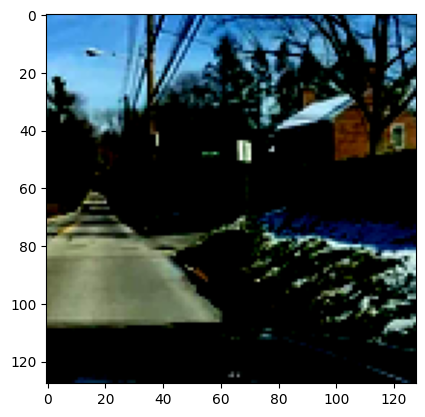

In [28]:
base_image = img_a.detach().cpu().numpy()[0].transpose(1, 2, 0)
plt.imshow(base_image)

### Image generated by the model

In [ ]:
fake_image = fake_b.detach().cpu().numpy()[0].transpose(1, 2, 0)
plt.imshow(fake_image)